# Quantum Assisted Phase Estimation

## Standard Methods

The standard QPE algorithm as shown below takes as input a unitary operator $U$ and an eigenvector of $U$, $\ket{\psi}$ and outputs a $k$-bit approximation to $\theta$ where

$$U\ket{\psi} = e^{2\pi i \theta} \ket{\psi}.$$

<img src="./figs/qpe.png" alt="drawing" width="600"/>

Some technicalities:

* When $2^k \theta$ has an exact k-bit approximation, we will measure it with certainty (in the noiseless case). However, if there is no exact k-bit approximation to $2^k \theta$ then we are guaranteed to measure the correct value with probability greater than approximately 40% (but the measurement histogram peaks around the true value).
* When $\ket{\psi}$ is not an exact eigenvector, it can be written as a superposition over the eigenbasis of $U$. Then its clear that the outcome of the measurement will be a superposition of measurement peaks about each eigenvalue. The relative amplitude of each peak will be related to the relative amplitude of the associated eigenvector of the input superposition. Hence for ground state calculations, as long as the overlap of the input state with the true groundstate isn't exponentially small, we will still measure the groundstate energy with sufficiently large probability. 


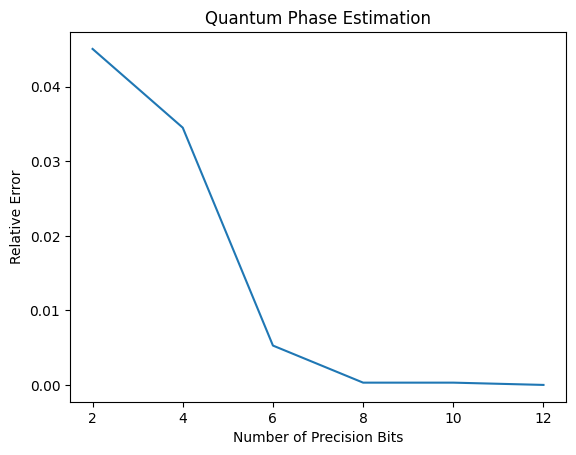

In [2]:
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt


def qft_circ(n: int, measure: bool = False):
    if measure:
        circ = QuantumCircuit(n, n)
    else:
        circ = QuantumCircuit(n)
    for control_index in range(n):
        circ.h(control_index)
        for rot_power in range(1, n-control_index):
            target_index = control_index+rot_power
            circ.cp(np.pi/(2**(rot_power)), control_index, target_index)
        # circ.barrier()
    if measure:
        circ.measure(range(n), range(n))
    return circ


def iqft_circ(n: int, measure: bool = False):
    if measure:
        circ = QuantumCircuit(n, n)
    else:
        circ = QuantumCircuit(n)
    for control_index in list(range(n))[::-1]:
        for rot_power in list(range(1, n-control_index))[::-1]:
            target_index = control_index+rot_power
            circ.cp(-np.pi/(2**(rot_power)), control_index, target_index)
        circ.h(control_index)
        # circ.barrier()
    if measure:
        circ.measure(range(n), range(n))
    return circ


def qpe_circ(U: QuantumCircuit, num_precision_bits: int, measure: bool = True):
    if measure:
        qpe = QuantumCircuit(
            U.num_qubits + num_precision_bits, num_precision_bits)
    else:
        qpe = QuantumCircuit(U.num_qubits + num_precision_bits)
    for i in range(num_precision_bits):
        qpe.h(i)
    for i in range(num_precision_bits):
        reps = 2**i
        control_U = U.control(1)
        for _ in range(reps):
            qpe.append(control_U, [
                       i] + list(range(num_precision_bits, U.num_qubits + num_precision_bits)))
        qpe.barrier()
    iqft = iqft_circ(num_precision_bits)
    qpe.append(iqft, list(range(num_precision_bits)))
    if measure:
        qpe.measure(range(num_precision_bits), range(num_precision_bits))
    return qpe

# Quick test
# u = QuantumCircuit(1)
# u.z(0)
# qpe = qpe_circ(u, 3)
# qpe.decompose().draw()

# Test:
# U is a simple phase gate with eigenvector |1>


def phase_gate(theta):
    return [[1, 0], [0, np.exp(2*np.pi*1j*theta)]]

# theta = np.pi / 4 # = 0.7853981633974483
# u = QuantumCircuit(1)
# u.unitary(phase_gate(theta), 0)
# precision = 8
# expected_output = bin(int((2**8) * theta))[2:].zfill(8) # = 11001001

# qc = QuantumCircuit(1 + precision, precision)
# qc.x(precision)
# qc.append(qpe_circ(u, precision), range(1 + precision), range(precision))

# shots = 1000
# backend = Aer.get_backend("qasm_simulator")
# job = execute(qc, backend=backend, shots=shots)
# result = job.result()
# counts = result.get_counts()
# plot_histogram(counts) # Remember qiskit reports qubits in reverse order!


# Let's repeat it to make sure the precision increases as we expect
precision_list = [2, 4, 6, 8, 10, 12]
theta_estimate = []
theta = np.pi / 4  # = 0.7853981633974483
for precision in precision_list:
    u = QuantumCircuit(1)
    u.unitary(phase_gate(theta), 0)
    expected_output = bin(int((2**8) * theta))[2:].zfill(8)  # = 11001001

    qc = QuantumCircuit(1 + precision, precision)
    qc.x(precision)
    qc.append(qpe_circ(u, precision), range(1 + precision), range(precision))

    shots = 1000
    backend = Aer.get_backend("qasm_simulator")
    job = execute(qc, backend=backend, shots=shots)
    result = job.result()
    counts = result.get_counts()
    most_likely_measurement = int(max(counts, key=counts.get)[::-1], 2)
    theta_estimate.append(most_likely_measurement / 2**precision)

relative_errors = [np.abs(1 - (t / theta)) for t in theta_estimate]
plt.plot(precision_list, relative_errors)
plt.title("Quantum Phase Estimation")
plt.ylabel("Relative Error")
plt.xlabel("Number of Precision Bits")
plt.show()


If you only care about a single eigenvalue and not any spectral information then a simpler alternative to calculate $\braket{\psi|U|\psi}$ is given by the Hadamard test. In the figure below, $b=0$ gives you the real part of $\braket{\psi|U|\psi}$ while $b=1$ gives you the imaginary part. 

<img src="./figs/HadamardTest.png" alt="drawing" width="200"/>



However, to overcome shot noise requires $\mathcal{O}(1/\epsilon^2)$ measurements for precision $\epsilon$. This is going to scale quite badly if we want chemically precise measruements. This is in contrast to the QPE algorithm where you only require a single shot to obtain a precise measurement with high probability - the precision is controlled by the number of precision bits used in the circuit. Unfortunately, quantum hardware is a long way from being able to implement the full QPE algorithm so we need an alternative. 

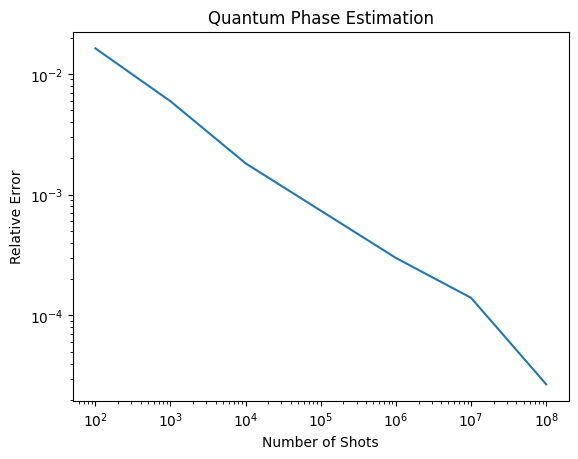

In [3]:
import cmath

def Hadamard_test(U: QuantumCircuit, A : QuantumCircuit, n_shots: int = 1024):
    control_U = U.control(1)
    backend = Aer.get_backend("qasm_simulator")
    shots = n_shots

    # real part
    qc = QuantumCircuit(U.num_qubits + 1, 1)
    qc.append(A, range(1, U.num_qubits + 1)) # state prep
    qc.h(0)
    qc.append(control_U, range(U.num_qubits + 1))
    qc.h(0)
    qc.measure(0, 0)
    job = execute(qc, backend=backend, shots=shots)
    result = job.result()
    counts = result.get_counts()

    counts0 = counts["0"] if "0" in counts else 0
    counts1 = counts["1"] if "1" in counts else 0

    re_part = (counts0 - counts1) / shots

    # imaginary part
    qc2 = QuantumCircuit(U.num_qubits + 1, 1)
    qc2.append(A, range(1, U.num_qubits + 1)) # state prep
    qc2.h(0)
    qc2.sdg(0)
    qc2.append(control_U, range(U.num_qubits + 1))
    qc2.h(0)
    qc2.measure(0,0)
    job2 = execute(qc2, backend=backend, shots=shots)
    result2 = job2.result()
    counts2 = result2.get_counts()

    counts20 = counts2["0"] if "0" in counts2 else 0
    counts21 = counts2["1"] if "1" in counts2 else 0

    im_part = (counts20 - counts21) / shots

    exp_value = re_part + 1j * im_part
    return exp_value

def eigenvalue_to_theta(val):
    phase = cmath.phase(val)
    if phase < 0: 
        phase += 2*np.pi 
    elif phase >= 2*np.pi:
        phase -= 2*np.pi
    return phase / (2*np.pi)

# Quick test
# u = QuantumCircuit(1)
# u.z(0)
# state_prep = QuantumCircuit(1)
# val = Hadamard_test(u, state_prep, n_shots=1000) # expect 1
# theta = eigenvalue_to_theta(val) # expect 0
# print(val)
# print(theta)

# Test precision
shot_list = [100, 1000, 10000, 1000000, 10000000, 100000000]
theta_estimate = []
theta = np.pi / 4  # = 0.7853981633974483
for shots in shot_list:
    u = QuantumCircuit(1)
    u.unitary(phase_gate(theta), 0)

    state_prep = QuantumCircuit(1)
    state_prep.x(0)

    val = Hadamard_test(u, state_prep, shots)
    theta_estimate.append(eigenvalue_to_theta(val))

relative_errors = [np.abs(1 - (t / theta)) for t in theta_estimate]
plt.loglog(shot_list, relative_errors)
plt.title("Quantum Phase Estimation")
plt.ylabel("Relative Error")
plt.xlabel("Number of Shots")
plt.show()

## Preliminaries

### Quantum Process Tomography

Quantum State Tomography (QST) is a standard process to reconstruct an arbitrary $n$-qubit state $\rho \in (\mathbb{C}^2)^{\otimes n}$. The state $\rho$ can be decomposed in the Pauli basis as 

$$\rho = \sum_{\vec{v}} \frac{Tr(\sigma_{v_1} \otimes ... \otimes \sigma_{v_n} \rho) \sigma_{v_1} \otimes ... \otimes \sigma_{v_n}}{2^n},$$

where $\vec{v} = \{0,1,2,3\}^n$ and $\sigma_i$ are the standard Pauli matrices. Then each weight in the sum can be obtained by measurement data since

$$Tr(\sigma_{v_1} \otimes ... \otimes \sigma_{v_n} \rho) = \braket{\sigma_{v_1} \otimes ... \otimes \sigma_{v_n}}.$$

An arbitrary quantum operator is a completely-positive, trace-preserving (CPTP) map $\mathcal{E} : (\mathbb{C}^2)^{\otimes n} \to (\mathbb{C}^2)^{\otimes n}$. Quantum Process Tomography (QPT) is a method for reconstructing $\mathcal{E}$ from a set of measurement results with no prior knowledge of $\mathcal{E}$. It is widely used for characterising noisy quantum gates implemented on real hardware. Similar to QST, the resources required for QPT scales with the dimension of the system and becomes infeasible for more than a handful of qubits. 

A general description of quantum process tomography can be found in many standard references, however we only need the single-qubit case. Note that the qubit of interest may be a part of a larger quantum register, however we only obtain the (possibly non-unitary) quantum operator acting on that qubit. We first prepare the four states $\ket{0}$, $\ket{1}$, $\ket{+} = (\ket{0} + \ket{1})/\sqrt{2}$, and $\ket{i} = (\ket{0} + i\ket{1})/\sqrt{2}$. We then perform QST on the transformed states

$$\mathcal{E}(\ket{0}\bra{0}),$$

$$\mathcal{E}(\ket{1}\bra{1}),$$

$$\mathcal{E}(\ket{+}\bra{+}),$$

$$\mathcal{E}(\ket{i}\bra{i}).$$

Then we define

$$\rho_1 = \mathcal{E}(\ket{0}\bra{0}),$$

$$\rho_4 = \mathcal{E}(\ket{1}\bra{1}),$$

$$\rho_2 = \mathcal{E}(\ket{+}\bra{+}) - i \mathcal{E}(\ket{i}\bra{i}) - (1-i) (\rho_1+\rho_4)/2,$$

$$\rho_2 = \mathcal{E}(\ket{+}\bra{+}) + i \mathcal{E}(\ket{i}\bra{i}) - (1+i) (\rho_1+\rho_4)/2,$$

We can now construct the so-called chi-matrix for the process $\mathcal{E}$,

$$\chi = \Lambda \begin{pmatrix} \rho_1 & \rho_2 \\ \rho_3 & \rho_4 \end{pmatrix} \Lambda,$$

where 

$$\Lambda = \begin{pmatrix} I & X \\ X & -I \end{pmatrix}.$$

The chi-matrix is related to the Choi-matrix by a change of basis,

$$\chi_{Choi} = \sum_{m,n} \chi_{m,n} |\sigma_m \rangle \rangle \langle \langle \sigma_n|,$$

where $|\sigma_i\rangle\rangle$ denotes a vectorised Pauli matrix. Then the Choi matrix can be converted to the evolution matrix, $M$, representing $\mathcal{E}$ by a permutation of its elements,

$$M_{m+d(n-1),j+d(k-1)} = {\chi_{Choi}}_{(j-1)d+m, (k-1)d+n},$$

for $j,k,m,n=1,2,...,d$ and $d$ is the dimension of the system. Then writing $\mathcal{E}(\rho_{in}) = \rho_{out}$ is equivalent to writing $M\rho_{in} = \rho_{out}$. In particular, $\mathcal{E}^2(\rho_{in}) = M^2\rho_{in}$. 

In [76]:
from qiskit import ClassicalRegister

def quantumStateTomography(prep_circ, qubit, shots=1024):
    """Perform quantum state tomography on the state prepared by a quantum circuit

    Given a quantum circuit that prepares some quantum state |a>, this function
    performs quantum state tomography on a given qubit to construct its density matrix

    Parameters
    -----------
    prep_circ : QuantumCircuit
        A Qiskit QuantumCircuit object that prepares the state of interest |a> on any number of qubits
    qubit : int
        The index of the qubit to perform tomography on
    shots : int
        The number of shots used per circuit. Default is 1024

    Returns
    --------
    state_dm : np.ndarray
        The density matrix of the given qubit after the given ciruict
    """
    backend = Aer.get_backend("qasm_simulator")
    Id = np.array([[1,0],[0,1]])
    X = np.array([[0,1],[1,0]])
    Y = np.array([[0,-1j],[1j,0]])
    Z = np.array([[1,0],[0,-1]])

    # X 
    x_circ = QuantumCircuit(prep_circ.num_qubits)
    x_circ.append(prep_circ, list(range(prep_circ.num_qubits)))
    x_circ.h(qubit)
    
    x_circ.add_register(ClassicalRegister(1))
    x_circ.measure(qubit, 0)
    
    jobx = execute(x_circ, backend=backend, shots=shots)
    resultx = jobx.result()
    countsx = resultx.get_counts()

    countsx0 = countsx["0"] if "0" in countsx else 0
    countsx1 = countsx["1"] if "1" in countsx else 0
    exp_X = countsx0/shots - countsx1/shots
    
    # Y
    y_circ = QuantumCircuit(prep_circ.num_qubits)
    y_circ.append(prep_circ, list(range(prep_circ.num_qubits)))
    y_circ.sdg(qubit)
    y_circ.h(qubit)
    
    y_circ.add_register(ClassicalRegister(1))
    y_circ.measure(qubit, 0)
    
    joby = execute(y_circ, backend=backend, shots=shots)
    resulty = joby.result()
    countsy = resulty.get_counts()
    
    countsy0 = countsy["0"] if "0" in countsy else 0
    countsy1 = countsy["1"] if "1" in countsy else 0
    exp_Y = countsy0/shots - countsy1/shots
    
    
    # Z
    z_circ = QuantumCircuit(prep_circ.num_qubits)
    z_circ.append(prep_circ, list(range(prep_circ.num_qubits)))
    
    z_circ.add_register(ClassicalRegister(1))
    z_circ.measure(qubit, 0)
    
    jobz = execute(z_circ, backend=backend, shots=shots)
    resultz = jobz.result()
    countsz = resultz.get_counts()
    
    countsz0 = countsz["0"] if "0" in countsz else 0
    countsz1 = countsz["1"] if "1" in countsz else 0
    exp_Z = countsz0/shots - countsz1/shots
    
    # Reconstruct
    state_dm = Id/2 + exp_X*X/2 + exp_Y*Y/2 + exp_Z*Z/2
    return state_dm

def quantumProcessTomography(circ, qubit, shots=1024):
    """Perform quantum process tomography

    Given a quantum circuit acting on any number of qubits, determine the process
    affecting the given qubit.

    Parameters
    -----------
    circ : QuantumCircuit
        A Qiskit QuantumCircuit object
    qubit : int
        The index of the qubit to perform tomography on
    shots : int
        The number of shots used per circuit. Default is 1024

    Returns
    --------
    chi : np.matrix
        The 4x4 chi matrix describing the process on the given qubit
    """
    prep1 = QuantumCircuit(circ.num_qubits)
    prep1.append(circ, list(range(circ.num_qubits)))
    
    prep2 = QuantumCircuit(circ.num_qubits)
    prep2.x(qubit)
    prep2.append(circ, list(range(circ.num_qubits)))
    
    prep3 = QuantumCircuit(circ.num_qubits)
    prep3.h(qubit)
    prep3.append(circ, list(range(circ.num_qubits)))
    
    prep4 = QuantumCircuit(circ.num_qubits)
    prep4.h(qubit)
    prep4.s(qubit)
    prep4.append(circ, list(range(circ.num_qubits)))
    
    qst1 = quantumStateTomography(prep1, qubit, shots)
    qst2 = quantumStateTomography(prep2, qubit, shots)
    qst3 = quantumStateTomography(prep3, qubit, shots)
    qst4 = quantumStateTomography(prep4, qubit, shots)
    
    rho1 = qst1
    rho4 = qst2
    rho2 = qst3 -1j*qst4 - (1-1j)*(rho1 + rho4)/2
    rho3 = qst3 +1j*qst4 - (1+1j)*(rho1 + rho4)/2
    
    Lambda = np.asmatrix(np.array([[1/2, 0, 0, 1/2], [0, 1/2, 1/2, 0], [0, 1/2, -1/2, 0], [1/2, 0, 0, -1/2]]))
    Rhos = np.asmatrix(np.array([
        [rho1[0,0], rho1[0,1], rho2[0,0], rho2[0,1]],
        [rho1[1,0], rho1[1,1], rho2[1,0], rho2[1,1]],
        [rho3[0,0], rho3[0,1], rho4[0,0], rho4[0,1]],
        [rho3[1,0], rho3[1,1], rho4[1,0], rho4[1,1]]
    ]))
    chi = np.matmul(Lambda, np.matmul(Rhos, Lambda))
    
    return chi
    
    """Convert a Choi matrix into an evolution matrix

    Convert a Choi matrix describing a quantum process on a single qubit
    into the corresponding evolution matrix

    Parameters
    -----------
    choi_matrix : np.matrix
        The Choi matrix of a quantum process
    
    Returns
    --------
    ev_matrix : np.matrix
        The corresponding evolution matrix for the quantum process given by Choi
    """

    ev_matrix = np.asmatrix(np.array([
        [choi_matrix[0, 0], choi_matrix[2, 0], choi_matrix[0, 2], choi_matrix[2, 2]],
        [choi_matrix[1, 0], choi_matrix[3, 0], choi_matrix[1, 2], choi_matrix[3, 2]],
        [choi_matrix[0, 1], choi_matrix[2, 1], choi_matrix[0, 3], choi_matrix[2, 3]],
        [choi_matrix[1, 1], choi_matrix[3, 1], choi_matrix[1, 3], choi_matrix[3, 3]]
    ]))

    return ev_matrix

def chiToOperatorSum(chi_matrix):

    evals, evecs = np.linalg.eig(chi_matrix)
    d = np.asmatrix(np.diag(evals))

    u = np.asmatrix([[evecs[:,0][0,0], evecs[:,1][0,0], evecs[:,2][0,0], evecs[:,3][0,0]],
                     [evecs[:,0][1,0], evecs[:,1][1,0], evecs[:,2][1,0], evecs[:,3][1,0]],
                     [evecs[:,0][2,0], evecs[:,1][2,0], evecs[:,2][2,0], evecs[:,3][2,0]],
                     [evecs[:,0][3,0], evecs[:,1][3,0], evecs[:,2][3,0], evecs[:,3][3,0]]
                     ])

    e0 = np.matrix([[1,0],[0,1]])
    e1 = np.matrix([[0,1],[1,0]])
    e2 = np.matrix([[0,1],[-1,0]])
    e3 = np.matrix([[1,0],[0,-1]])

    op0 = np.sqrt(d[0,0]) * (u[0,0]*e0 + u[1,0]*e1 + u[2,0]*e2 + u[3,0]*e3)
    op1 = np.sqrt(d[1,1]) * (u[0,1]*e0 + u[1,1]*e1 + u[2,1]*e2 + u[3,1]*e3)
    op2 = np.sqrt(d[2,2]) * (u[0,2]*e0 + u[1,2]*e1 + u[2,2]*e2 + u[3,2]*e3)
    op3 = np.sqrt(d[3,3]) * (u[0,3]*e0 + u[1,3]*e1 + u[2,3]*e2 + u[3,3]*e3)
    ops = [op0, op1, op2, op3]
    
    return ops

def opsToSuperOp(ops):
    superOp = np.zeros((4,4), dtype=complex)

    for i in range(4):
        superOp += np.kron(ops[i].conjugate(), ops[i])

    return 0.5*superOp

### IQFT-MPO

Tensor networks are representations of quantum many-body systems. The key idea of tensor networks is to replace the exponentially large tensors associated with the standard Hilbert space of a quantum system with a collection (or network) of smaller tensors. 

It is well established that the core part of the Quantum Fourier Transform (QFT) (that is, without the final SWAP gates) has small entanglement. More precisely, the Schmidt coefficients of the QFT operator decay exponentially. Therefore, the QFT admits an efficient classical representation as a tensor network, specifically a Matrix Product Operator (MPO). The same is true for the inverse QFT (IQFT).

To obtain the MPO representation of the IQFT (IQFT-MPO) we use the zip-up algorithm as described in this [paper](https://arxiv.org/abs/2210.08468). 

In [28]:
def qft_mpo_3_qubits():

    ##############
    # Definitions
    ##############

    Id_gate = np.identity(2) 
    zero_gate = np.zeros((2,2))
    projector_00 = np.array([[1,0],[0,0]])
    projector_11 = np.array([[0,0],[0,1]])
    copy_gate = np.array([projector_00, projector_11])
    H_gate = np.array([[1/np.sqrt(2),1/np.sqrt(2)],[1/np.sqrt(2),-1/np.sqrt(2)]])

    def phase_gate(theta):
        return np.array([[1,0],[0,np.exp(complex(0,1)*theta)]])

    # index order up, right, left
    def phase_tensor_rank_3(theta):
        return np.array([Id_gate, phase_gate(theta)])

    # index order up, down, right, left
    def phase_tensor_rank_4(theta):
        return np.array([[Id_gate, zero_gate], [zero_gate, phase_gate(theta)]])

    ####################
    # Zip-up Algorithm
    ####################

    # First contract all H gates into the neighbouring tensor
    contraction1 = np.einsum('dcb,ba->dca', copy_gate.copy(), H_gate.copy())
    contraction2 = np.einsum('gf,dife->dige', H_gate.copy(), phase_tensor_rank_4(np.pi/2))
    contraction3 = np.einsum('nm,jml->jnl', H_gate.copy(), phase_tensor_rank_3(np.pi/2))

    # Now start the zip-up process
    contraction4 = np.einsum('jnl,ilk->ijnk', contraction3, phase_tensor_rank_3(np.pi/4))
    contraction4 = np.reshape(contraction4, (4,4))
    u1, s1, vh1 = np.linalg.svd(contraction4, full_matrices=False)
    u1s1 = u1[:, :4] * s1
    u1s1 = np.reshape(u1s1, (2,2,4))
    vh1 = np.reshape(vh1, (4,2,2))

    contraction5 = np.einsum('jhg,dige->dijhe', copy_gate.copy(), contraction2)
    contraction6 = np.einsum('dijhe,ijo->dohe', contraction5, u1s1)

    # Move the orthogonality centre back to the bottom
    contraction6 = np.moveaxis(contraction6, [1], [0])
    contraction6 = np.reshape(contraction6, (4,8))
    u2, s2, vh2 = np.linalg.svd(contraction6, full_matrices=False)
    u2s2 = u2[:, :4] * s2
    u2s2 = u2s2.T
    vh2 = np.reshape(vh2, (4,2,2,2))
    vh2 = np.moveaxis(vh2, [0], [1])
    contraction7 = np.einsum('qo,onk->qnk', u2s2, vh1)

    # The final matrices in the MPO
    final1 = contraction1
    final2 = vh2 
    final3 = contraction7

    return final1, final2, final3

def qft_mpo_n_qubits_no_truncation(n):

    ##############
    # Definitions
    ##############

    Id_gate = np.identity(2) 
    zero_gate = np.zeros((2,2))
    projector_00 = np.array([[1,0],[0,0]])
    projector_11 = np.array([[0,0],[0,1]])
    copy_gate = np.array([projector_00, projector_11])
    H_gate = np.array([[1/np.sqrt(2),1/np.sqrt(2)],[1/np.sqrt(2),-1/np.sqrt(2)]])

    def phase_gate(theta):
        return np.array([[1,0],[0,np.exp(complex(0,1)*theta)]])

    # index order up, right, left
    def phase_tensor_rank_3(theta):
        return np.array([Id_gate, phase_gate(theta)])

    # index order up, down, right, left
    def phase_tensor_rank_4(theta):
        return np.array([[Id_gate, zero_gate], [zero_gate, phase_gate(theta)]])
    
    if n == 3:
        return qft_mpo_3_qubits()
    
    else:
        # Contract the H gate
        tensor_1 = np.einsum('dcb,ba->dca', copy_gate.copy(), H_gate.copy())

        ##########
        # Zip up
        ##########
        qft_mpo_n_minus_1_qubits = qft_mpo_n_qubits_no_truncation(n-1)
        output_tensors = []

        # First Contraction
        final_n_minus_1 = qft_mpo_n_minus_1_qubits[-1]
        tensor_n = np.einsum('mkj,lji->lmki', final_n_minus_1, phase_tensor_rank_3(np.pi/(2**(n-1))))

        # First SVD
        tensor_n_rows = tensor_n.shape[0] * tensor_n.shape[1]
        tensor_n = np.reshape(tensor_n, (tensor_n_rows, 4))
        un, sn, tensor_n = np.linalg.svd(tensor_n, full_matrices=False)
        num_singular_vals = sn.shape[0]
        unsn = un[:, :num_singular_vals] * sn
        unsn = np.reshape(unsn, (2,final_n_minus_1.shape[0],num_singular_vals))
        tensor_n = np.reshape(tensor_n, (num_singular_vals,2,2))

        output_tensors.append(tensor_n)

        feed_in_matrix = unsn
        for val in range(2,n-1):
            # Contraction
            final_n_minus_val = qft_mpo_n_minus_1_qubits[-val]
            tensor_n_minus_val = np.einsum('vmkj,ulji->uvlmki', final_n_minus_val, phase_tensor_rank_4(np.pi/(2**(n-val))))
            tensor_n_minus_val = np.einsum('uvlmki,lms->uvski', tensor_n_minus_val, feed_in_matrix)

            # SVD
            tensor_n_minus_val = np.reshape(tensor_n_minus_val, (tensor_n_minus_val.shape[0]*tensor_n_minus_val.shape[1], tensor_n_minus_val.shape[2]*tensor_n_minus_val.shape[3]*tensor_n_minus_val.shape[4]))
            u_n_minus_val, s_n_minus_val, tensor_n_minus_val = np.linalg.svd(tensor_n_minus_val, full_matrices=False)
            num_singular_vals = s_n_minus_val.shape[0]
            u_n_minus_val_s_n_minus_val = u_n_minus_val[:, :num_singular_vals] * s_n_minus_val 
            u_n_minus_val_s_n_minus_val = np.reshape(u_n_minus_val_s_n_minus_val, (2, final_n_minus_val.shape[0], num_singular_vals))
            tensor_n_minus_val = np.reshape(tensor_n_minus_val, (num_singular_vals, feed_in_matrix.shape[2], 2, 2))

            output_tensors.append(tensor_n_minus_val)
            feed_in_matrix = u_n_minus_val_s_n_minus_val

        # Final Contraction
        final_1 = qft_mpo_n_minus_1_qubits[0]
        tensor_2 = np.einsum('mkj,dlji->dlmki', final_1, phase_tensor_rank_4(np.pi/2))
        tensor_2 = np.einsum('dlmki,lmn->dnki', tensor_2, feed_in_matrix)
        output_tensors.append(tensor_2)

        # Reverse the list order
        output_tensors = output_tensors[::-1]

        # Return the orthogonality centre to the bottom
        final_tensors = [tensor_1]

        tensor_2 = np.moveaxis(tensor_2, [1], [0])
        tensor_2 = np.reshape(tensor_2, (tensor_2.shape[0], tensor_2.shape[1]*tensor_2.shape[2]*tensor_2.shape[3]))
        u2, s2, tensor_2 = np.linalg.svd(tensor_2, full_matrices=False)
        num_singular_vals = s2.shape[0]
        u2s2 = u2[:, :num_singular_vals] * s2
        u2s2 = u2s2.T
        tensor_2 = np.reshape(tensor_2, (num_singular_vals, 2,2,2))
        tensor_2 = np.moveaxis(tensor_2, [0], [1])
        final_tensors.append(tensor_2)

        feed_in_matrix = u2s2
        for val in range(3,n):
            tensor_val = output_tensors[val-2]
            tensor_val = np.einsum('adcb,ea->edcb', tensor_val, feed_in_matrix)
            tensor_val = np.moveaxis(tensor_val, [1], [0])
            tensor_val = np.reshape(tensor_val, (tensor_val.shape[0], tensor_val.shape[1]*tensor_val.shape[2]*tensor_val.shape[3]))
            uval, sval, tensor_val = np.linalg.svd(tensor_val, full_matrices=False)
            num_singular_vals = sval.shape[0]
            uvalsval = uval[:, :num_singular_vals] * sval
            uvalsval = uvalsval.T
            tensor_val = np.reshape(tensor_val, (num_singular_vals,feed_in_matrix.shape[0],2,2))
            tensor_val = np.moveaxis(tensor_val, [0], [1])

            final_tensors.append(tensor_val)
            feed_in_matrix = uvalsval
        
        tensor_n = output_tensors[-1]
        tensor_n = np.einsum('ab,bdc->adc', feed_in_matrix, tensor_n)
        final_tensors.append(tensor_n)

        return final_tensors
    
def qft_mpo_n_qubits(n, max_bond_dimension):

    ##############
    # Definitions
    ##############

    Id_gate = np.identity(2) 
    zero_gate = np.zeros((2,2))
    projector_00 = np.array([[1,0],[0,0]])
    projector_11 = np.array([[0,0],[0,1]])
    copy_gate = np.array([projector_00, projector_11])
    H_gate = np.array([[1/np.sqrt(2),1/np.sqrt(2)],[1/np.sqrt(2),-1/np.sqrt(2)]])

    def phase_gate(theta):
        return np.array([[1,0],[0,np.exp(complex(0,1)*theta)]])

    # index order up, right, left
    def phase_tensor_rank_3(theta):
        return np.array([Id_gate, phase_gate(theta)])

    # index order up, down, right, left
    def phase_tensor_rank_4(theta):
        return np.array([[Id_gate, zero_gate], [zero_gate, phase_gate(theta)]])
    
    if n == 3:
        return qft_mpo_3_qubits()
    
    else:
        # Contract the H gate
        tensor_1 = np.einsum('dcb,ba->dca', copy_gate.copy(), H_gate.copy())

        ##########
        # Zip up
        ##########
        qft_mpo_n_minus_1_qubits = qft_mpo_n_qubits(n-1, max_bond_dimension)
        output_tensors = []

        # First Contraction
        final_n_minus_1 = qft_mpo_n_minus_1_qubits[-1]
        tensor_n = np.einsum('mkj,lji->lmki', final_n_minus_1, phase_tensor_rank_3(np.pi/(2**(n-1))))

        # First SVD
        tensor_n_rows = tensor_n.shape[0] * tensor_n.shape[1]
        tensor_n = np.reshape(tensor_n, (tensor_n_rows, 4))
        un, sn, tensor_n = np.linalg.svd(tensor_n, full_matrices=False)
        num_singular_vals = sn.shape[0]
        bond_dim = max_bond_dimension if max_bond_dimension < num_singular_vals else num_singular_vals
        unsn = un[:, :bond_dim] * sn[:bond_dim]
        unsn = np.reshape(unsn, (2,final_n_minus_1.shape[0],bond_dim))
        tensor_n = tensor_n[:bond_dim, :]
        tensor_n = np.reshape(tensor_n, (bond_dim,2,2))

        output_tensors.append(tensor_n)

        feed_in_matrix = unsn
        for val in range(2,n-1):
            # Contraction
            final_n_minus_val = qft_mpo_n_minus_1_qubits[-val]
            tensor_n_minus_val = np.einsum('vmkj,ulji->uvlmki', final_n_minus_val, phase_tensor_rank_4(np.pi/(2**(n-val))))
            tensor_n_minus_val = np.einsum('uvlmki,lms->uvski', tensor_n_minus_val, feed_in_matrix)

            # SVD
            tensor_n_minus_val = np.reshape(tensor_n_minus_val, (tensor_n_minus_val.shape[0]*tensor_n_minus_val.shape[1], tensor_n_minus_val.shape[2]*tensor_n_minus_val.shape[3]*tensor_n_minus_val.shape[4]))
            u_n_minus_val, s_n_minus_val, tensor_n_minus_val = np.linalg.svd(tensor_n_minus_val, full_matrices=False)
            num_singular_vals = s_n_minus_val.shape[0]
            bond_dim = max_bond_dimension if max_bond_dimension < num_singular_vals else num_singular_vals
            u_n_minus_val_s_n_minus_val = u_n_minus_val[:, :bond_dim] * s_n_minus_val[:bond_dim]
            u_n_minus_val_s_n_minus_val = np.reshape(u_n_minus_val_s_n_minus_val, (2, final_n_minus_val.shape[0], bond_dim))
            tensor_n_minus_val = tensor_n_minus_val[:bond_dim, :]
            tensor_n_minus_val = np.reshape(tensor_n_minus_val, (bond_dim, feed_in_matrix.shape[2], 2, 2))

            output_tensors.append(tensor_n_minus_val)
            feed_in_matrix = u_n_minus_val_s_n_minus_val

        # Final Contraction
        final_1 = qft_mpo_n_minus_1_qubits[0]
        tensor_2 = np.einsum('mkj,dlji->dlmki', final_1, phase_tensor_rank_4(np.pi/2))
        tensor_2 = np.einsum('dlmki,lmn->dnki', tensor_2, feed_in_matrix)
        output_tensors.append(tensor_2)

        # Reverse the list order
        output_tensors = output_tensors[::-1]

        # Return the orthogonality centre to the bottom
        final_tensors = [tensor_1]

        tensor_2 = np.moveaxis(tensor_2, [1], [0])
        tensor_2 = np.reshape(tensor_2, (tensor_2.shape[0], tensor_2.shape[1]*tensor_2.shape[2]*tensor_2.shape[3]))
        u2, s2, tensor_2 = np.linalg.svd(tensor_2, full_matrices=False)
        num_singular_vals = s2.shape[0]
        bond_dim = max_bond_dimension if max_bond_dimension < num_singular_vals else num_singular_vals
        u2s2 = u2[:, :bond_dim] * s2[:bond_dim]
        u2s2 = u2s2.T
        tensor_2 = tensor_2[:bond_dim, :]
        tensor_2 = np.reshape(tensor_2, (bond_dim, 2,2,2))
        tensor_2 = np.moveaxis(tensor_2, [0], [1])
        final_tensors.append(tensor_2)

        feed_in_matrix = u2s2
        for val in range(3,n):
            tensor_val = output_tensors[val-2]
            tensor_val = np.einsum('adcb,ea->edcb', tensor_val, feed_in_matrix)
            tensor_val = np.moveaxis(tensor_val, [1], [0])
            tensor_val = np.reshape(tensor_val, (tensor_val.shape[0], tensor_val.shape[1]*tensor_val.shape[2]*tensor_val.shape[3]))
            uval, sval, tensor_val = np.linalg.svd(tensor_val, full_matrices=False)
            num_singular_vals = sval.shape[0]
            bond_dim = max_bond_dimension if max_bond_dimension < num_singular_vals else num_singular_vals
            uvalsval = uval[:, :bond_dim] * sval[:bond_dim]
            uvalsval = uvalsval.T
            tensor_val = tensor_val[:bond_dim, :]
            tensor_val = np.reshape(tensor_val, (bond_dim,feed_in_matrix.shape[0],2,2))
            tensor_val = np.moveaxis(tensor_val, [0], [1])

            final_tensors.append(tensor_val)
            feed_in_matrix = uvalsval
        
        tensor_n = output_tensors[-1]
        tensor_n = np.einsum('ab,bdc->adc', feed_in_matrix, tensor_n)
        final_tensors.append(tensor_n)

        return final_tensors
    
def iqft_mpo_3_qubits():

    ##############
    # Definitions
    ##############

    Id_gate = np.identity(2) 
    zero_gate = np.zeros((2,2))
    projector_00 = np.array([[1,0],[0,0]])
    projector_11 = np.array([[0,0],[0,1]])
    copy_gate = np.array([projector_00, projector_11])
    H_gate = np.array([[1/np.sqrt(2),1/np.sqrt(2)],[1/np.sqrt(2),-1/np.sqrt(2)]])

    def phase_gate(theta):
        return np.array([[1,0],[0,np.exp(complex(0,1)*theta)]])

    # index order up, right, left
    def phase_tensor_rank_3(theta):
        return np.array([Id_gate, phase_gate(theta)])

    # index order up, down, right, left
    def phase_tensor_rank_4(theta):
        return np.array([[Id_gate, zero_gate], [zero_gate, phase_gate(theta)]])

    ####################
    # Zip-up Algorithm
    ####################

    # First contract all H gates into the neighbouring tensor
    contraction1 = np.einsum('lba,cb->lca', copy_gate.copy(), H_gate.copy())
    contraction2 = np.einsum('fe,lngf->lnge', H_gate.copy(), phase_tensor_rank_4(-np.pi/2))
    contraction3 = np.einsum('ih,mji->mjh', H_gate.copy(), phase_tensor_rank_3(-np.pi/2))

    # Now start the zip-up process
    contraction4 = np.einsum('mjh,nkj->mnkh', contraction3, phase_tensor_rank_3(-np.pi/4))
    contraction4 = np.reshape(contraction4, (4,4))
    u1, s1, vh1 = np.linalg.svd(contraction4, full_matrices=False)
    u1s1 = u1[:, :4] * s1
    u1s1 = np.reshape(u1s1, (2,2,4))
    vh1 = np.reshape(vh1, (4,2,2))

    contraction5 = np.einsum('med, lnge, mno -> logd', copy_gate.copy(), contraction2, u1s1)

    # Move the orthogonality centre back to the bottom
    contraction5 = np.moveaxis(contraction5, [1], [0])
    contraction5 = np.reshape(contraction5, (4,8))
    u2, s2, vh2 = np.linalg.svd(contraction5, full_matrices=False)
    u2s2 = u2[:, :4] * s2
    u2s2 = u2s2.T
    vh2 = np.reshape(vh2, (4,2,2,2))
    vh2 = np.moveaxis(vh2, [0], [1])
    contraction6 = np.einsum('po,okh->pkh', u2s2, vh1)

    # The final matrices in the MPO
    final1 = contraction1
    final2 = vh2 
    final3 = contraction6

    return final1, final2, final3

def iqft_mpo_n_qubits_no_truncation(n):

    ##############
    # Definitions
    ##############

    Id_gate = np.identity(2) 
    zero_gate = np.zeros((2,2))
    projector_00 = np.array([[1,0],[0,0]])
    projector_11 = np.array([[0,0],[0,1]])
    copy_gate = np.array([projector_00, projector_11])
    H_gate = np.array([[1/np.sqrt(2),1/np.sqrt(2)],[1/np.sqrt(2),-1/np.sqrt(2)]])

    def phase_gate(theta):
        return np.array([[1,0],[0,np.exp(complex(0,1)*theta)]])

    # index order up, right, left
    def phase_tensor_rank_3(theta):
        return np.array([Id_gate, phase_gate(theta)])

    # index order up, down, right, left
    def phase_tensor_rank_4(theta):
        return np.array([[Id_gate, zero_gate], [zero_gate, phase_gate(theta)]])
    
    if n == 3:
        return iqft_mpo_3_qubits()
    
    else:
        # Contract the H gate
        tensor_1 = np.einsum('abc, db -> adc', copy_gate.copy(), H_gate.copy())

        ##########
        # Zip up
        ##########
        iqft_mpo_n_minus_1_qubits = iqft_mpo_n_qubits_no_truncation(n-1)
        output_tensors = []

        # First Contraction
        final_n_minus_1 = iqft_mpo_n_minus_1_qubits[-1]
        tensor_n = np.einsum('ilk,jml->ijmk', final_n_minus_1, phase_tensor_rank_3(-np.pi/(2**(n-1))))

        # First SVD
        tensor_n_rows = tensor_n.shape[0] * tensor_n.shape[1]
        tensor_n = np.reshape(tensor_n, (tensor_n_rows, 4))
        un, sn, tensor_n = np.linalg.svd(tensor_n, full_matrices=False)
        num_singular_vals = sn.shape[0]
        unsn = un[:, :num_singular_vals] * sn
        unsn = np.reshape(unsn, (final_n_minus_1.shape[0],2,num_singular_vals))
        tensor_n = np.reshape(tensor_n, (num_singular_vals,2,2))

        output_tensors.append(tensor_n)

        feed_in_matrix = unsn
        for val in range(2,n-1):
            # Contraction
            final_n_minus_val = iqft_mpo_n_minus_1_qubits[-val]
            tensor_n_minus_val = np.einsum('ijn,oirq,pjsr->opnsq', feed_in_matrix, final_n_minus_val, phase_tensor_rank_4(-np.pi/(2**(n-val))))

            # SVD
            tensor_n_minus_val = np.reshape(tensor_n_minus_val, (tensor_n_minus_val.shape[0]*tensor_n_minus_val.shape[1], tensor_n_minus_val.shape[2]*tensor_n_minus_val.shape[3]*tensor_n_minus_val.shape[4]))
            u_n_minus_val, s_n_minus_val, tensor_n_minus_val = np.linalg.svd(tensor_n_minus_val, full_matrices=False)
            num_singular_vals = s_n_minus_val.shape[0]
            u_n_minus_val_s_n_minus_val = u_n_minus_val[:, :num_singular_vals] * s_n_minus_val 
            u_n_minus_val_s_n_minus_val = np.reshape(u_n_minus_val_s_n_minus_val, (final_n_minus_val.shape[0], 2, num_singular_vals))
            tensor_n_minus_val = np.reshape(tensor_n_minus_val, (num_singular_vals, feed_in_matrix.shape[2], 2, 2))

            output_tensors.append(tensor_n_minus_val)
            feed_in_matrix = u_n_minus_val_s_n_minus_val

        # Final Contraction
        final_1 = iqft_mpo_n_minus_1_qubits[0]
        tensor_2 = np.einsum('ghi, ged, chfe -> cifd', feed_in_matrix, final_1, phase_tensor_rank_4(np.pi/2))
        output_tensors.append(tensor_2)

        # Reverse the list order
        output_tensors = output_tensors[::-1]

        # Return the orthogonality centre to the bottom
        final_tensors = [tensor_1]

        tensor_2 = np.moveaxis(tensor_2, [1], [0])
        tensor_2 = np.reshape(tensor_2, (tensor_2.shape[0], tensor_2.shape[1]*tensor_2.shape[2]*tensor_2.shape[3]))
        u2, s2, tensor_2 = np.linalg.svd(tensor_2, full_matrices=False)
        num_singular_vals = s2.shape[0]
        u2s2 = u2[:, :num_singular_vals] * s2
        u2s2 = u2s2.T
        tensor_2 = np.reshape(tensor_2, (num_singular_vals, 2,2,2))
        tensor_2 = np.moveaxis(tensor_2, [0], [1])
        final_tensors.append(tensor_2)

        feed_in_matrix = u2s2
        for val in range(3,n):
            tensor_val = output_tensors[val-2]
            tensor_val = np.einsum('adcb,ea->edcb', tensor_val, feed_in_matrix)
            tensor_val = np.moveaxis(tensor_val, [1], [0])
            tensor_val = np.reshape(tensor_val, (tensor_val.shape[0], tensor_val.shape[1]*tensor_val.shape[2]*tensor_val.shape[3]))
            uval, sval, tensor_val = np.linalg.svd(tensor_val, full_matrices=False)
            num_singular_vals = sval.shape[0]
            uvalsval = uval[:, :num_singular_vals] * sval
            uvalsval = uvalsval.T
            tensor_val = np.reshape(tensor_val, (num_singular_vals,feed_in_matrix.shape[0],2,2))
            tensor_val = np.moveaxis(tensor_val, [0], [1])

            final_tensors.append(tensor_val)
            feed_in_matrix = uvalsval
        
        tensor_n = output_tensors[-1]
        tensor_n = np.einsum('ab,bdc->adc', feed_in_matrix, tensor_n)
        final_tensors.append(tensor_n)

        return final_tensors

def iqft_mpo_n_qubits(n, max_bond_dimension):
    
    ##############
    # Definitions
    ##############

    Id_gate = np.identity(2) 
    zero_gate = np.zeros((2,2))
    projector_00 = np.array([[1,0],[0,0]])
    projector_11 = np.array([[0,0],[0,1]])
    copy_gate = np.array([projector_00, projector_11])
    H_gate = np.array([[1/np.sqrt(2),1/np.sqrt(2)],[1/np.sqrt(2),-1/np.sqrt(2)]])

    def phase_gate(theta):
        return np.array([[1,0],[0,np.exp(complex(0,1)*theta)]])

    # index order up, right, left
    def phase_tensor_rank_3(theta):
        return np.array([Id_gate, phase_gate(theta)])

    # index order up, down, right, left
    def phase_tensor_rank_4(theta):
        return np.array([[Id_gate, zero_gate], [zero_gate, phase_gate(theta)]])
    
    if n == 3:
        return iqft_mpo_3_qubits()
    
    else:
        # Contract the H gate
        tensor_1 = np.einsum('abc, db -> adc', copy_gate.copy(), H_gate.copy())

        ##########
        # Zip up
        ##########
        iqft_mpo_n_minus_1_qubits = iqft_mpo_n_qubits(n-1, max_bond_dimension)
        output_tensors = []

        # First Contraction
        final_n_minus_1 = iqft_mpo_n_minus_1_qubits[-1]
        tensor_n = np.einsum('ilk,jml->ijmk', final_n_minus_1, phase_tensor_rank_3(-np.pi/(2**(n-1))))

        # First SVD
        tensor_n_rows = tensor_n.shape[0] * tensor_n.shape[1]
        tensor_n = np.reshape(tensor_n, (tensor_n_rows, 4))
        un, sn, tensor_n = np.linalg.svd(tensor_n, full_matrices=False)
        num_singular_vals = sn.shape[0]
        bond_dim = max_bond_dimension if max_bond_dimension < num_singular_vals else num_singular_vals
        unsn = un[:, :bond_dim] * sn[:bond_dim]
        unsn = np.reshape(unsn, (final_n_minus_1.shape[0],2,bond_dim))
        tensor_n = tensor_n[:bond_dim, :]
        tensor_n = np.reshape(tensor_n, (bond_dim,2,2))

        output_tensors.append(tensor_n)

        feed_in_matrix = unsn
        for val in range(2,n-1):
            # Contraction
            final_n_minus_val = iqft_mpo_n_minus_1_qubits[-val]
            tensor_n_minus_val = np.einsum('ijn,oirq,pjsr->opnsq', feed_in_matrix, final_n_minus_val, phase_tensor_rank_4(-np.pi/(2**(n-val))))

            # SVD
            tensor_n_minus_val = np.reshape(tensor_n_minus_val, (tensor_n_minus_val.shape[0]*tensor_n_minus_val.shape[1], tensor_n_minus_val.shape[2]*tensor_n_minus_val.shape[3]*tensor_n_minus_val.shape[4]))
            u_n_minus_val, s_n_minus_val, tensor_n_minus_val = np.linalg.svd(tensor_n_minus_val, full_matrices=False)
            num_singular_vals = s_n_minus_val.shape[0]
            bond_dim = max_bond_dimension if max_bond_dimension < num_singular_vals else num_singular_vals
            u_n_minus_val_s_n_minus_val = u_n_minus_val[:, :bond_dim] * s_n_minus_val[:bond_dim]
            u_n_minus_val_s_n_minus_val = np.reshape(u_n_minus_val_s_n_minus_val, (final_n_minus_val.shape[0], 2, bond_dim))
            tensor_n_minus_val = tensor_n_minus_val[:bond_dim, :]
            tensor_n_minus_val = np.reshape(tensor_n_minus_val, (bond_dim, feed_in_matrix.shape[2], 2, 2))

            output_tensors.append(tensor_n_minus_val)
            feed_in_matrix = u_n_minus_val_s_n_minus_val

        # Final Contraction
        final_1 = iqft_mpo_n_minus_1_qubits[0]
        tensor_2 = np.einsum('ghi, ged, chfe -> cifd', feed_in_matrix, final_1, phase_tensor_rank_4(np.pi/2))
        output_tensors.append(tensor_2)

        # Reverse the list order
        output_tensors = output_tensors[::-1]

        # Return the orthogonality centre to the bottom
        final_tensors = [tensor_1]

        tensor_2 = np.moveaxis(tensor_2, [1], [0])
        tensor_2 = np.reshape(tensor_2, (tensor_2.shape[0], tensor_2.shape[1]*tensor_2.shape[2]*tensor_2.shape[3]))
        u2, s2, tensor_2 = np.linalg.svd(tensor_2, full_matrices=False)
        num_singular_vals = s2.shape[0]
        bond_dim = max_bond_dimension if max_bond_dimension < num_singular_vals else num_singular_vals
        u2s2 = u2[:, :bond_dim] * s2[:bond_dim]
        u2s2 = u2s2.T
        tensor_2 = tensor_2[:bond_dim, :]
        tensor_2 = np.reshape(tensor_2, (bond_dim, 2,2,2))
        tensor_2 = np.moveaxis(tensor_2, [0], [1])
        final_tensors.append(tensor_2)

        feed_in_matrix = u2s2
        for val in range(3,n):
            tensor_val = output_tensors[val-2]
            tensor_val = np.einsum('adcb,ea->edcb', tensor_val, feed_in_matrix)
            tensor_val = np.moveaxis(tensor_val, [1], [0])
            tensor_val = np.reshape(tensor_val, (tensor_val.shape[0], tensor_val.shape[1]*tensor_val.shape[2]*tensor_val.shape[3]))
            uval, sval, tensor_val = np.linalg.svd(tensor_val, full_matrices=False)
            num_singular_vals = sval.shape[0]
            bond_dim = max_bond_dimension if max_bond_dimension < num_singular_vals else num_singular_vals
            uvalsval = uval[:, :bond_dim] * sval[:bond_dim]
            uvalsval = uvalsval.T
            tensor_val = tensor_val[:bond_dim, :]
            tensor_val = np.reshape(tensor_val, (bond_dim,feed_in_matrix.shape[0],2,2))
            tensor_val = np.moveaxis(tensor_val, [0], [1])

            final_tensors.append(tensor_val)
            feed_in_matrix = uvalsval
        
        tensor_n = output_tensors[-1]
        tensor_n = np.einsum('ab,bdc->adc', feed_in_matrix, tensor_n)
        final_tensors.append(tensor_n)

        return final_tensors

## The Algorithm

Here's the idea. When the input to QPE is an exact eigenvector it remains unchanged by the controlled unitaries. So the back-action on a control qubit will be the same for sequential applications of controlled-U. I.e. The effect of C-$U^2$ will be the same as applying the back-action from C-$U$ twice in a row. So, take the following circuit

<img src="./figs/cu.png" alt="drawing" width="100"/>

and perform quantum process tomography on the control qubit to get the evolution matrix $M$. Then we know that the evolution matrix of this circuit

<img src="./figs/cu2.png" alt="drawing" width="100"/>

is just $M^2$. So this means we can get the reduced density matrix for any number of control qubits from this one process tomography calculation (which is only on one qubit so it's easy to do). Then we evolve these density matrices using the IQFT-MPO to obtain the MPO representation of the output from which we can obtain the phase estimate. 

[[ 5.0054e-01+0.0000e+00j -3.1500e-04-1.6850e-03j -8.4000e-04+0.0000e+00j
   0.0000e+00+1.8000e-04j]
 [-3.1500e-04+1.6850e-03j  3.5502e-01+0.0000e+00j  0.0000e+00-3.5273e-01j
   1.5900e-03+0.0000e+00j]
 [-8.4000e-04+0.0000e+00j  0.0000e+00+3.5273e-01j -3.5502e-01+0.0000e+00j
  -3.1500e-04-1.9350e-03j]
 [ 0.0000e+00-1.8000e-04j  1.5900e-03+0.0000e+00j -3.1500e-04+1.9350e-03j
   4.9946e-01+0.0000e+00j]]
[matrix([[-0.00160959-3.00605698e-04j,  0.26966586-6.54018696e-01j],
        [ 0.26966586+6.54019058e-01j,  0.00177923+1.11427838e-04j]]), matrix([[ 0.49161898+0.09528594j, -0.26037302+0.43004317j],
        [ 0.11807422+0.48865404j,  0.4894911 -0.09528594j]]), matrix([[-0.27267156+0.45905217j,  0.42869525+0.17748544j],
        [ 0.42832347-0.17748544j,  0.39854337+0.34973513j]]), matrix([[ 0.6097219 +0.30396477j,  0.15424425+0.09304246j],
        [ 0.17654248-0.04008736j, -0.61463499+0.30396477j]])]
[[ 5.00002681e-01+0.00000000e+00j -1.77448629e-04+1.00876238e-03j
  -1.77448629e-04-1.0087

/opt/homebrew/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


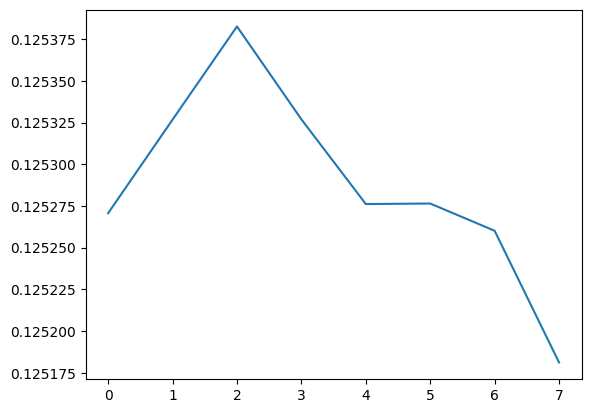

In [77]:
from qiskit.quantum_info import DensityMatrix

def qft_unitary(n):
    circ = qft_circ(n)
    backend = Aer.get_backend("unitary_simulator")
    job = execute(circ, backend=backend)
    result = job.result()
    return np.asmatrix(result.get_unitary(circ, 18))

def iqft_unitary(n):
    circ = iqft_circ(n)
    backend = Aer.get_backend("unitary_simulator")
    job = execute(circ, backend=backend)
    result = job.result() 
    return np.asmatrix(result.get_unitary(circ, 18))

def qape(unitary : QuantumCircuit, state_prep_circ : QuantumCircuit, num_precision_bits : int, mpo_on : bool = False):
    
    # Quantum Process Tomography
    circ = QuantumCircuit(1+unitary.num_qubits)
    circ.append(state_prep_circ, list(range(1, circ.num_qubits)))
    control_U = unitary.control(1)
    circ.append(control_U, list(range(circ.num_qubits)))

    chi = quantumProcessTomography(circ, 0, shots=100000)
    print(chi)
    ops = chiToOperatorSum(chi)
    print(ops)
    ev = opsToSuperOp(ops)
    print(ev)

    initial_state = np.array([0.5,0.5,0.5,0.5])
    
    if mpo_on:
        # IQFT-MPO contraction
        iqft_tensors = iqft_mpo_n_qubits(num_precision_bits, 2)
        qft_tensors = qft_mpo_n_qubits(num_precision_bits, 2)
        
        new_tensors = []
        for i in range(num_precision_bits):
            temp_state = np.asmatrix(initial_state.reshape((4,1)))
            for _ in range(2**i):
                temp_state = np.matmul(ev, temp_state)

            temp_state = np.asmatrix(np.array([[temp_state[0,0], temp_state[2,0]],[temp_state[1,0], temp_state[3,0]]]))
            temp_state = (1/np.trace(temp_state)) * temp_state
            qft_tensor = qft_tensors[i]
            iqft_tensor = iqft_tensors[i]

            if i == 0 or i == num_precision_bits-1:
                new_tensors.append(np.einsum('abc, db, efd -> aefc', iqft_tensor, temp_state, qft_tensor))
            else:
                new_tensors.append(np.einsum('abcd, ec, fghe -> afbghd',  iqft_tensor, temp_state, qft_tensor))
        return new_tensors
    
    else:
        temp_states = []
        for i in range(num_precision_bits):
            temp_state = np.asmatrix(initial_state.reshape((4,1)))
            for _ in range(2**i):
                temp_state = np.matmul(ev, temp_state)
            temp_state = np.asmatrix(np.array([[temp_state[0,0], temp_state[2,0]],[temp_state[1,0], temp_state[3,0]]]))
            temp_states.append(temp_state)
        for i in range(num_precision_bits-1):
            temp_states[i+1] = np.kron(temp_states[i], temp_states[i+1]) 
        # full_dm = DensityMatrix(temp_states[-1])
        # print(full_dm.probabilities_dict())
        full_dm = temp_states[-1]
        qft = qft_unitary(num_precision_bits)
        iqft = iqft_unitary(num_precision_bits)

        # iqft = iqft_circ(num_precision_bits)
        # output = full_dm.evolve(iqft)

        output = np.matmul(iqft, np.matmul(full_dm, qft))
        return output

# Test
precision_list = [3]
theta_estimate = [] 
# theta = np.pi / 4 # = 0.7853981633974483
theta = 1/(2**precision_list[0])
for precision in precision_list:
    u = QuantumCircuit(1)
    u.unitary(phase_gate(theta), 0)

    state_prep = QuantumCircuit(1)
    state_prep.x(0)

    output = qape(u, state_prep, precision)
    # print(output.probabilities_dict())

    outcomes = range(2**precision)
    probabilities = []
    for i in outcomes:
        probabilities.append(output[i,i])

    print(sum(probabilities))
    max_val = outcomes[probabilities.index(max(probabilities))]
    print(theta * (2**precision))
    print(max_val)
    print(theta)
    print(max_val / 2**precision)
    plt.plot(outcomes, probabilities)

# Test
# precision_list = [6]
# theta_estimate = []
# theta = np.pi / 4  # = 0.7853981633974483
# for precision in precision_list:
#     u = QuantumCircuit(1)
#     u.unitary(phase_gate(theta), 0)
    
#     state_prep = QuantumCircuit(1)
#     state_prep.x(0)

#     output_tensors = qape(u, state_prep, precision, True)

#     left_legs = list(range(precision))
#     right_legs = list(range(precision, 2*precision))
#     inner_legs = list(range(2*precision, 2*precision + 2*(precision-1)))

#     indices_list = []
#     indices_list.append([inner_legs[0], inner_legs[1], right_legs[0], left_legs[0]])
#     for i in range(1, precision-1):
#         indices_list.append([inner_legs[2*(i-1)], inner_legs[2*(i-1)+1], inner_legs[2*(i-1)+2], inner_legs[2*(i-1)+3], right_legs[i], left_legs[i]])
#     indices_list.append([inner_legs[-2], inner_legs[-1], right_legs[-1], left_legs[-1]])

#     input_list = []
#     for i in range(precision):
#         input_list.append(output_tensors[i])
#         input_list.append(indices_list[i])
#     density_matrix = np.einsum(*input_list, right_legs+left_legs).reshape((2**precision, 2**precision))

#     zero = np.array([1,0]).reshape((2))
#     one = np.array([0,1]).reshape((2))

#     outcomes = range(2**precision)
#     probabilities = []

#     for i in outcomes:
#         to_be_tensored = []
#         bin_i = bin(i)[2:].zfill(precision)
#         for j in range(precision):
#             to_append = zero if bin_i[j] == "0" else one
#             to_be_tensored.append(to_append)
#         for j in range(precision-1):
#             to_be_tensored[j+1] = np.kron(to_be_tensored[j], to_be_tensored[j+1])
#         vec = to_be_tensored[-1][::-1].reshape((2**precision, 1))

#         probability_i = float(np.matmul(vec.T, np.matmul(density_matrix, vec)).real)
#         probabilities.append(probability_i)
#         print(i, probability_i)
    
    # print(sum(probabilities))
    # print(theta * (2**precision))
    # pairs = zip(outcomes, probabilities)
    # sorted_pairs = sorted(pairs, key=lambda x: x[0])
    # x_data = [x for x,_ in sorted_pairs]
    # y_data = [y for _,y in sorted_pairs]
    # max_val = x_data[y_data.index(max(y_data))]
    # print(max_val)
    # print(theta)
    # print(max_val / 2**precision)
    # plt.plot(x_data, y_data)

# relative_errors = [np.abs(1 - (t / theta)) for t in theta_estimate]
# plt.plot(precision_list, relative_errors)
# plt.title("Quantum Assisted Phase Estimation")
# plt.ylabel("Relative Error")
# plt.xlabel("Number of Precision Bits")
# plt.show()